##### Copyright 2023 Melchor Lafuente Duque

# IMAGE TO AUDIO - IDCT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import scipy.io.wavfile as wavfile
import scipy.fftpack as sp
import scipy.signal as s
import cupy as cp
from PIL import Image
import imageio.v2 as imageio
import os
import cv2

# Functions to read and write wav files

In [2]:
def read_wav(file_name, dir_name_input = "INPUT"):
    file_location = join(dir_name_input, file_name + ".wav")
    sample_rate, signal = wavfile.read(file_location)
    
    # If the signal is stereo, we transform it to mono:
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]
        signal = np.mean([left_channel, right_channel], axis=0)   
        
    return sample_rate, signal

def write_wav(file_name, sr, signal, output_dir_name = "OUTPUT"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    file_name_output = os.path.join(output_path, file_name + ".wav")
    wavfile.write(file_name_output, sr, signal.astype('int16'))

## SETUP

We define the GPU device that we are going to use, in my case, I have three devices that I could use. So I will use one that is not being used by the previous process, the number one for example:

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" #0,1,2,3

We define some other functions that we'll be using:

## Functions to plot signals and images

In [4]:
def plot_signal(sr, signal, file_name, file_suffix = "wav"):
    # Compute time axis in seconds
    time = np.arange(len(signal)) / float(sr)
    duration = time.max()

    # Plot audio signal
    fig, ax = plt.subplots()

    ax.plot(time, signal)
    
    # Add a title and axis labels
    file_location = join(file_name + "." + file_suffix)
    
    ax.set_title(file_location)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (A)")

    plt.show()

In [5]:
def plot_image(img, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
def plot_slice(img, title, from_row = 0, to_row = -1, from_col = 0, to_col = -1):
    plt.figure(figsize=(6, 4))
    plt.imshow(img[from_row:to_row,from_col:to_col])
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
def plot_freq_array(freq_array):
    print("The image below has a dimension of: ", freq_array.T.shape)

    # Display the frequency domain image
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.imshow(freq_array.T, aspect='auto', origin='lower')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (segment index)')
    fig.show()

## Functions to read images and their range of frequencies

In [8]:
def read_max_min(dir_name_input, signal_name = "ORIGINAL", max_filename = "max", min_filename = "min"):
    
    max_filename = signal_name + "_" + max_filename + ".txt"
    min_filename = signal_name + "_" + min_filename + ".txt"
    
    file_location_max = join(dir_name_input, max_filename)
    file_location_min = join(dir_name_input, min_filename)
    
    freq_max = np.loadtxt(file_location_max, dtype=np.float64)
    freq_min = np.loadtxt(file_location_min, dtype=np.float64)
    return freq_max, freq_min

In [9]:
def read_image(dir_name_input = "OUTPUT_3", filename = "image", img_suffix = "png"):
    img_filename = filename + "." + img_suffix
    file_location_img = join(dir_name_input, img_filename)
    
    return cv2.imread(file_location_img) #BGR 

# IMAGE TO AUDIO:

## Read Images

We'll work with the original image of color divided in 3 channels: Blue, Green, Red, as well as with the gray image obtained by combining these channels into a single one:

In [10]:
# Load image
image = read_image(filename = "final_image_combined") #BGR 

# Transform to grey scale
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [11]:
image.shape, grey_image.shape

((662, 21341, 3), (662, 21341))

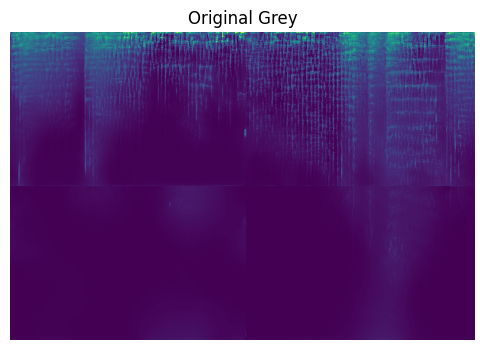

In [12]:
plot_image(grey_image[:,:1000], "Original Grey")

## Fixing the noise

As can be seen in the previous images, a clearly delimited strip appears in the middle of the image, the place where the cut from the previous process appeared. So, let's try to improve this noise on the horizontal axis.

To do this, we're going to grab some rows from the middle of the image and apply our own smoothing algorithm. This algorithm takes our image and performs a vertical smoothing operation on its lower half by averaging the pixel values between each row and the row directly below it. The process is performed twice to enhance the smoothing effect. The original image is not modified, and the smoothed version is stored in the variable `image_2`.

In [13]:
image_2 = image.copy()
rows, cols, channels = image_2.shape

# Calculate the height of the segment as half of the total number of rows
segment_height = rows // 2

# Loop through each channel in the image (B, G, R)
for channel in range(channels):
    
    # Perform the vertical smoothing process twice for better results
    for smoothness in range(2):
        
        # Initialize 'aux' to the row just below the segment to be smoothed
        aux = segment_height + 2
        
        # Iterate over the last four rows of the bottom segment
        for i in range(segment_height - 4, segment_height):
            
            # If the current row is not the last row of the bottom segment
            if i < (segment_height - 1):
                # Apply vertical smoothing by taking the average of the current row and the row below it
                image_2[i, :, channel] = (image_2[i - 1, :, channel] + image_2[i, :, channel]) // 2 
                
                # Apply vertical smoothing to the corresponding row in the upper segment
                image_2[aux, :, channel] = (image_2[aux + 1, :, channel] + image_2[aux, :, channel]) // 2 

            # If the current row is the last row of the bottom segment
            else:
                # Apply vertical smoothing by taking the average of the row above and below the current row
                image_2[i, :, channel] = (image_2[i - 1, :, channel] + image_2[i+1, :, channel] ) // 2
            
            # Move 'aux' one row up for the next iteration to process the previous row in the bottom segment
            aux -= 1

grey_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

Then we will see how the improvement is actually appreciated:

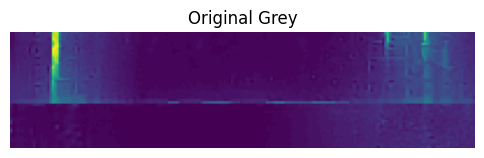

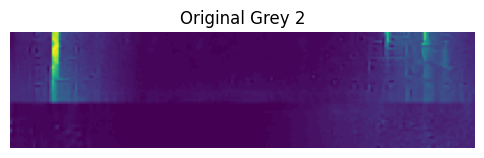

In [14]:
plot_slice(grey_image, 'Original Grey', from_row = 300, to_row = 350, to_col = 200)
plot_slice(grey_image_2, 'Original Grey 2', from_row = 300, to_row = 350, to_col = 200)

## Returning the original range of values to the GREY IMAGES

Let's now return the range of these images to their original range taking into account the maximum and minimum frequencies that we had before applying the style transfer algorithm to the songs. Then, we have two possible ranges: The one of the original song and the one from the style song. We will try both and see what happens.

In [15]:
read_max_min(dir_name_input = "OUTPUT_2/STYLE", signal_name = "STYLE")

(array(6.32002088), array(0.))

In [16]:
read_max_min(dir_name_input = "OUTPUT_2/ORIGIN", signal_name = "ORIGINAL")

(array(5.06326177), array(0.))

### With GREY IMAGE and the range of the ORIGINAL SONG

The image below has a dimension of:  (662, 21341)


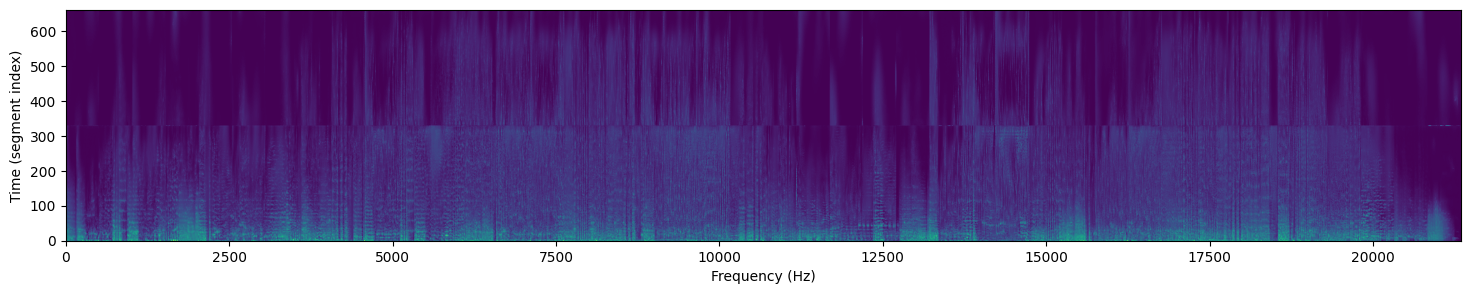

In [17]:
# read the image as a numpy array
img_float64 = np.asarray(grey_image).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_2/ORIGIN", signal_name = "ORIGINAL")

# return the original values
imgr_omm_GREY = ((freq_max - freq_min) * img_float64) + freq_min #imgr: image reconstructed; omm: original max-min frequencies

# Display the frequency domain image
plot_freq_array(imgr_omm_GREY.T)

### With GREY IMAGE and the range of the STYLE SONG

The image below has a dimension of:  (662, 21341)


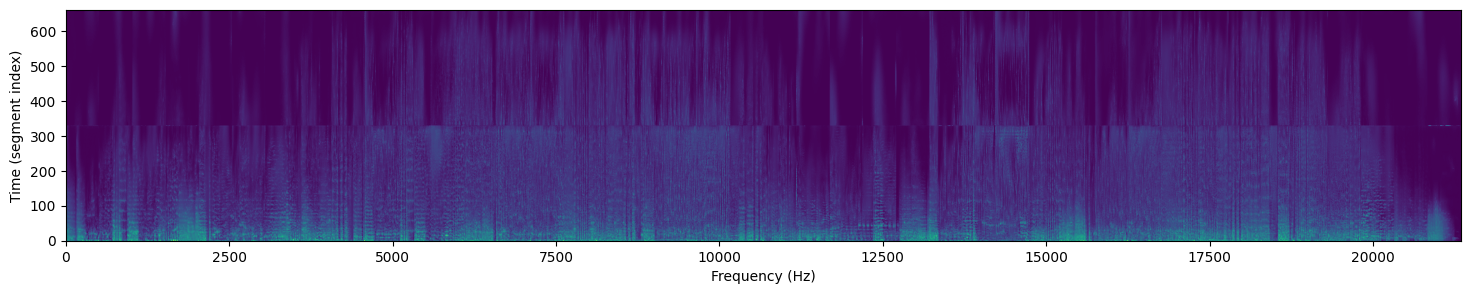

In [18]:
# read the image as a numpy array
img_float64 = np.asarray(grey_image).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_2/STYLE", signal_name = "STYLE")

# return the original values
imgr_smm_GREY = ((freq_max - freq_min) * img_float64) + freq_min #imr: image reconstructed; smm: style max-min frequencies

# Display the frequency domain image
plot_freq_array(imgr_smm_GREY.T)

### With GREY IMAGE 2 and the range of the ORIGINAL SONG

The image below has a dimension of:  (662, 21341)


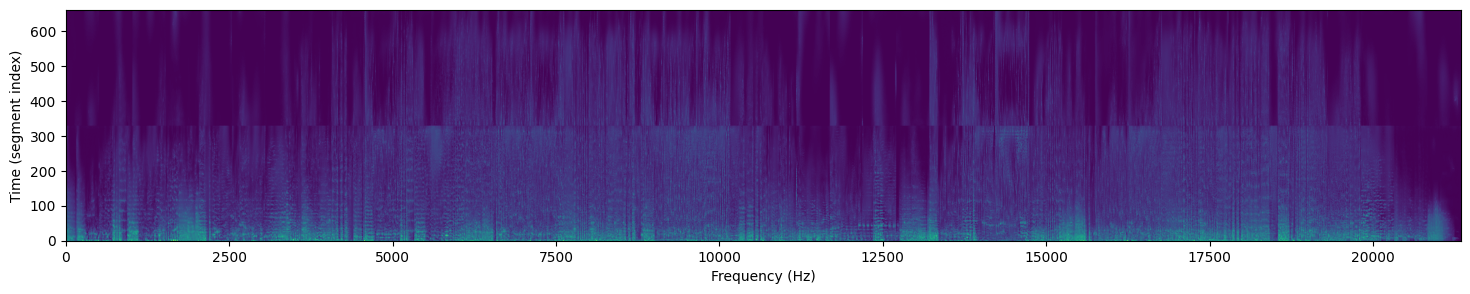

In [19]:
# read the image as a numpy array
img_float64 = np.asarray(grey_image_2).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_2/ORIGIN", signal_name = "ORIGINAL")

# return the original values
imgr_omm_GREY_2 = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(imgr_omm_GREY_2.T)

### With GREY IMAGE 2 and the range of the STYLE SONG

The image below has a dimension of:  (662, 21341)


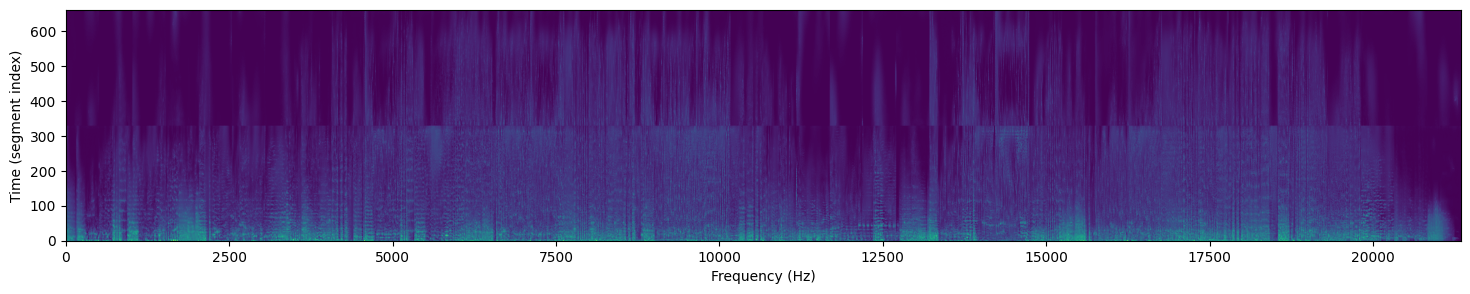

In [20]:
# read the image as a numpy array
img_float64 = np.asarray(grey_image_2).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_2/STYLE", signal_name = "STYLE")

# return the original values
imgr_smm_GREY_2 = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(imgr_smm_GREY_2.T)

## Freq ARRAY TO AUDIO

Now we want to transform the frequency domain representation into a time domain representation. That is, we are going to apply the IDCT. 

To do this, we will first load the following elements:
* The matrix of signs.
* The sample rate of the original song.
* The number of samples we used.
* The length of each segment.

Again, we have two possibilities for each of these elements, the ones from the original song:

In [21]:
mat_signs_o = np.load(join("OUTPUT_2/ORIGIN", "ORIGINAL_mat_signs.npy"))
sample_rate_o = np.loadtxt(join("OUTPUT_2/ORIGIN", "ORIGINAL_sample_rate.txt"), dtype=int)
n_samples_o = np.loadtxt(join("OUTPUT_2/ORIGIN", "ORIGINAL_n_samples.txt"), dtype=int)
segment_length_o = np.loadtxt(join("OUTPUT_2/ORIGIN", "ORIGINAL_segment_length.txt"), dtype=int)

And the ones from the style song:

In [22]:
mat_signs_s = np.load(join("OUTPUT_2/STYLE", "STYLE_mat_signs.npy"))
sample_rate_s = np.loadtxt(join("OUTPUT_2/STYLE", "STYLE_sample_rate.txt"), dtype=int)
n_samples_s = np.loadtxt(join("OUTPUT_2/STYLE", "STYLE_n_samples.txt"), dtype=int)
segment_length_s = np.loadtxt(join("OUTPUT_2/STYLE", "STYLE_segment_length.txt"), dtype=int)

Anyway, except for the matrices of signs the rest of the elements are equal for both songs since they had the same length and configuration in the DCT algorithm:

In [23]:
(sample_rate_o == sample_rate_s) & (n_samples_o == n_samples_s) & (segment_length_o == segment_length_s)

True

This means we are going to use the following elements always and we will variate only in the matrices of signs to do our experiments:

In [24]:
sample_rate = sample_rate_o
n_samples = n_samples_o
segment_length = segment_length_o

Although we have only used the default sign matrices of the original song and the style song, we could also try combining them or doing more complex things with them to vary the results:

In [25]:
mat_signs_os = (np.load(join("OUTPUT_2/ORIGIN", "ORIGINAL_mat_signs.npy")) + np.load(join("OUTPUT_2/STYLE", "STYLE_mat_signs.npy"))) / 2

In [26]:
mat_signs_os

array([[-1.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  1.],
       [-1.,  0., -1., ..., -1.,  0.,  1.],
       ...,
       [-1., -1., -1., ...,  0.,  1.,  1.],
       [-1.,  1.,  1., ...,  1.,  0., -1.],
       [ 0.,  0.,  1., ..., -1.,  0.,  0.]])

However, we are not going to analyze this possibility.
<br>
<br>
After loading all the values we need for the IDCT, we'll define the function that will apply the IDCT as well as an auxiliar function that will help in that process.

In [27]:
def obtain_dct_segments(freq_array, mat_signs):
    return (np.exp(freq_array) - 1) * mat_signs

In [28]:
def write_reconstructed_signal(freq_array, mat_signs, segment_length, sample_rate, n_samples, output_dir_name = "OUTPUT", file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE"):
    # Inverse the process to reconstruct the original signal
    reconstructed_signal = np.zeros(n_samples)

    dct_segments = obtain_dct_segments(freq_array, mat_signs)

    for i, segment in enumerate(dct_segments):
        segment_signal = sp.idct(segment, type=2, norm='ortho')
        reconstructed_signal[i * segment_length : i * segment_length + segment_length] += segment_signal

    # Normalize the reconstructed signal to [-1, 1] range
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

    # Scale the signal back to the original 16-bit range
    reconstructed_signal = np.int16(reconstructed_signal * (2**15))
    
    # Write the reconstructed signal to a new .wav file
    write_wav(file_name, sr = sample_rate, signal = reconstructed_signal, output_dir_name = output_dir_name)

At this point we have all the necesary ingredients to reconstruct the audios by applying the IDCT.

# Audio Reconstructions

We are going to test the following combinations of elements to which we will apply the IDCT:

* **R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY:** <u>Grey Image</u> in range of the <u>original</u> song's <u>frequencies</u> using the <u>original</u> song's <u>matrix of signs</u>.
<br>
* **R_STYLE_MAXMIN_ORIGINAL_MAT_GREY:** <u>Grey Image</u> in range of the <u>style</u> song's <u>frequencies</u> using the <u>original</u> song's <u>matrix of signs</u>.
<br>
* **R_ORIGINAL_MAXMIN_STYLE_MAT_GREY:** <u>Grey Image</u> in range of the <u>original</u> song's <u>frequencies</u> using the <u>style</u> song's <u>matrix of signs</u>.
<br>
* **R_STYLE_MAXMIN_STYLE_MAT_GREY:** <u>Grey Image</u> in range of the <u>style</u> song's <u>frequencies</u> using the <u>style</u> song's <u>matrix of signs</u>.
<br>
<br>
* **R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY_2:** <u>Grey Image 2</u> in range of the <u>original</u> song's <u>frequencies</u> using the <u>original</u> song's <u>matrix of signs</u>.
<br>
* **R_STYLE_MAXMIN_ORIGINAL_MAT_GREY_2:** <u>Grey Image 2</u> in range of the <u>style</u> song's <u>frequencies</u> using the <u>original</u> song's <u>matrix of signs</u>.
<br>
* **R_ORIGINAL_MAXMIN_STYLE_MAT_GREY_2:** <u>Grey Image 2</u> in range of the <u>original</u> song's <u>frequencies</u> using the <u>style</u> song's <u>matrix of signs</u>.
<br>
* **R_STYLE_MAXMIN_STYLE_MAT_GREY_2:** <u>Grey Image 2</u> in range of the <u>style</u> song's <u>frequencies</u> using the <u>style</u> song's <u>matrix of signs</u>.


In [29]:
# GREY
write_reconstructed_signal(imgr_omm_GREY.T, mat_signs_o, segment_length, sample_rate, n_samples, file_name = "R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY", output_dir_name = "OUTPUT_4")
write_reconstructed_signal(imgr_smm_GREY.T, mat_signs_o, segment_length, sample_rate, n_samples, file_name = "R_STYLE_MAXMIN_ORIGINAL_MAT_GREY", output_dir_name = "OUTPUT_4")
write_reconstructed_signal(imgr_omm_GREY.T, mat_signs_s, segment_length, sample_rate, n_samples, file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_GREY", output_dir_name = "OUTPUT_4")
write_reconstructed_signal(imgr_smm_GREY.T, mat_signs_s, segment_length, sample_rate, n_samples, file_name = "R_STYLE_MAXMIN_STYLE_MAT_GREY", output_dir_name = "OUTPUT_4")

# GREY 2
write_reconstructed_signal(imgr_omm_GREY_2.T, mat_signs_o, segment_length, sample_rate, n_samples, file_name = "R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY_2", output_dir_name = "OUTPUT_4")
write_reconstructed_signal(imgr_smm_GREY_2.T, mat_signs_o, segment_length, sample_rate, n_samples, file_name = "R_STYLE_MAXMIN_ORIGINAL_MAT_GREY_2", output_dir_name = "OUTPUT_4")
write_reconstructed_signal(imgr_omm_GREY_2.T, mat_signs_s, segment_length, sample_rate, n_samples, file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_GREY_2", output_dir_name = "OUTPUT_4")
write_reconstructed_signal(imgr_smm_GREY_2.T, mat_signs_s, segment_length, sample_rate, n_samples, file_name = "R_STYLE_MAXMIN_STYLE_MAT_GREY_2", output_dir_name = "OUTPUT_4")

<br>After listening to all these audio combinations and according to my auditory perception, the mix that seems closest to our original purpose is **R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY**. In this audio, both the original audio and the style audio can be appreciated.
<br>
<br>
This is the signal of **R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY**:
<br>

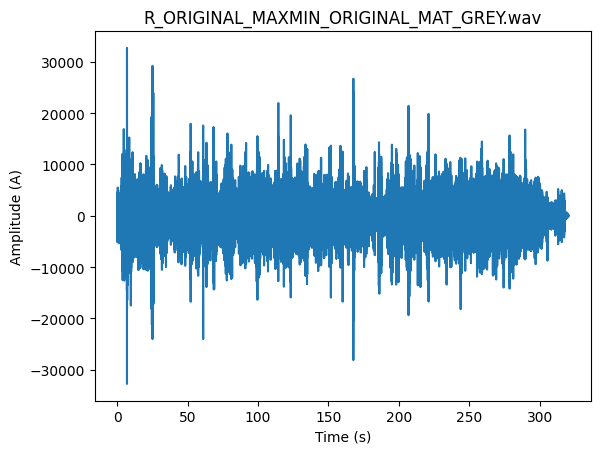

In [30]:
sample_rate_omm_om_GREY, reconstructed_signal_omm_om_GREY = read_wav(file_name = "R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY", dir_name_input = "OUTPUT_4")
plot_signal(sample_rate_omm_om_GREY, reconstructed_signal_omm_om_GREY, file_name = "R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY", file_suffix = "wav")

Note that by the combination **R_ORIGINAL_MAXMIN_ORIGINAL_MAT_GREY**, the resulting reconstructed audio sounds just like a simple reconstruction of the original audio with some added noise. This means that the power that sign matrices have in the IDCT algorithm is very significant, being the cornerstone of said algorithm, while using one frequency range or another does not alter the result too much. 
<br>
<br>
In addition, having tried to remove some "noise" in the middle of the grey image, getting **grey 2**, has simply caused some frequencies to be omitted, removing some information and getting a **worse result**.
<br>
<br>
So now that we have a combination of elements that fits what we want, we're going to replicate the reconstruction process for each channel of the original image:

The image below has a dimension of:  (662, 21341)


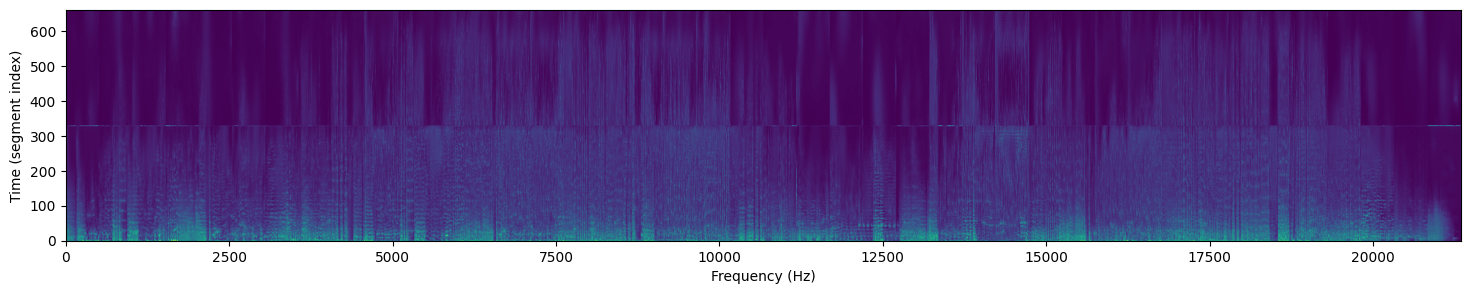

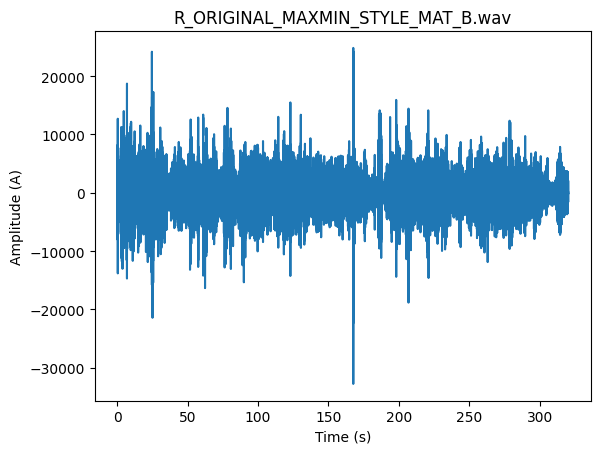

The image below has a dimension of:  (662, 21341)


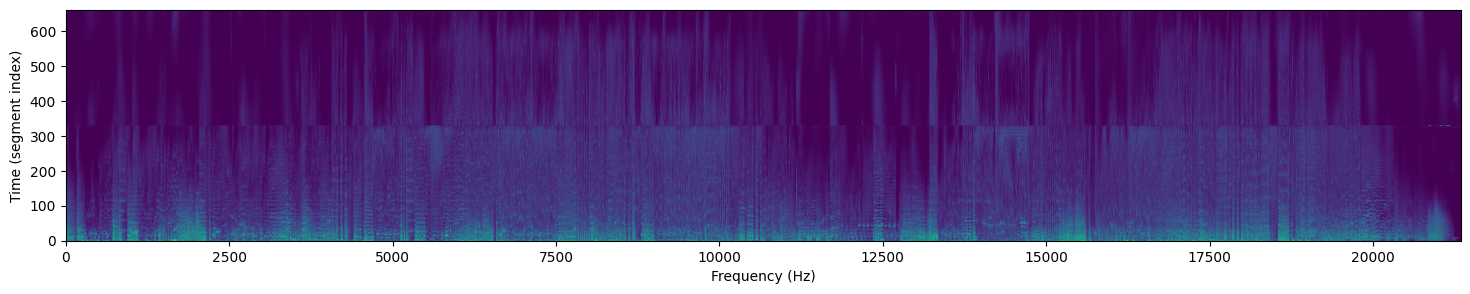

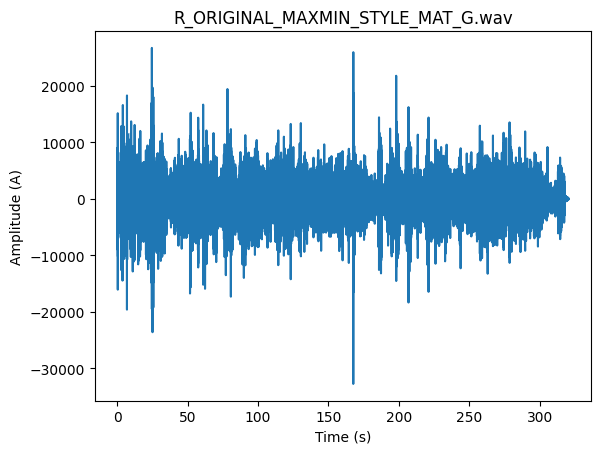

The image below has a dimension of:  (662, 21341)


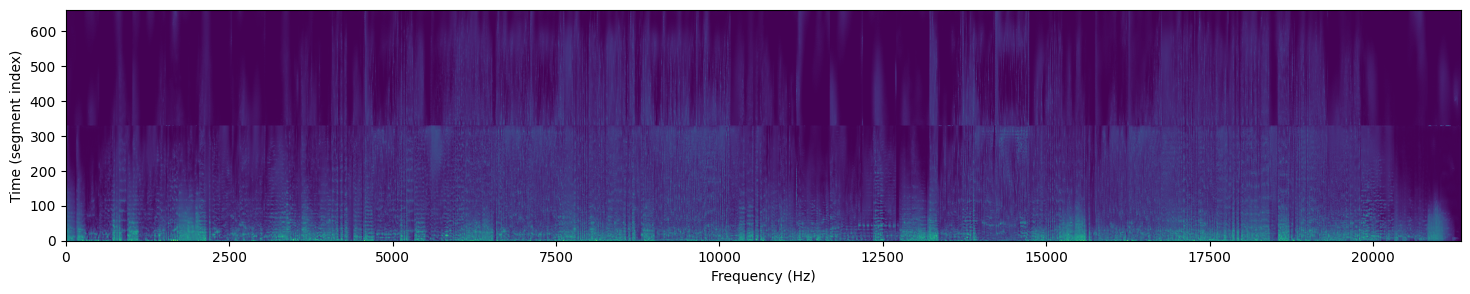

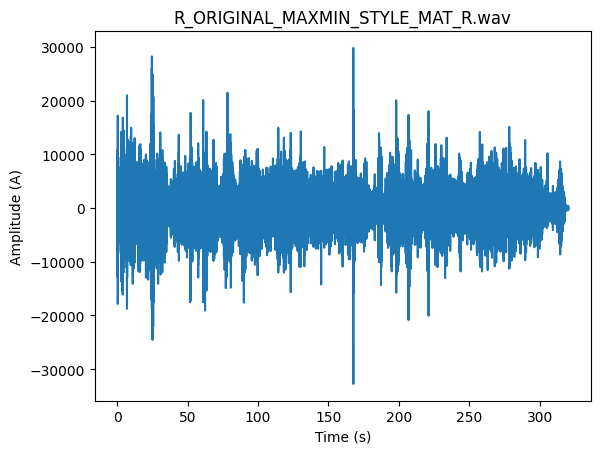

In [32]:
channels = ["B", "G", "R"]
freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_2/ORIGIN", signal_name = "ORIGINAL")

for channel in range(3):
    # read the image as a numpy array
    img_float64 = np.asarray(image[:,:,channel]).astype("float64")

    # normalize the array to the range [0,1]
    img_float64 = (img_float64) / 255.0

    # return the original values
    img_reconstructed = ((freq_max - freq_min) * img_float64) + freq_min

    # Display the frequency domain image
    plot_freq_array(img_reconstructed.T)

    write_reconstructed_signal(img_reconstructed.T, 
                               mat_signs_s, 
                               segment_length, 
                               sample_rate, 
                               n_samples, 
                               file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_" + channels[channel], 
                               output_dir_name = "OUTPUT_4")
    
    # Plot the resulting signal
    sample_rate, reconstructed_signal = read_wav(file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_" + channels[channel], dir_name_input = "OUTPUT_4")
    plot_signal(sample_rate, reconstructed_signal, file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_" + channels[channel], file_suffix = "wav")
